In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd
from autograd import grad, elementwise_grad
import autograd.numpy as np
import autograd.scipy.stats.norm as norm
from autograd.scipy.special import erf
from autograd.scipy.special import expit as sigmoid
from autograd.numpy.linalg import solve, cholesky
from autograd.misc.optimizers import adam
from autograd.misc.flatten import flatten_func

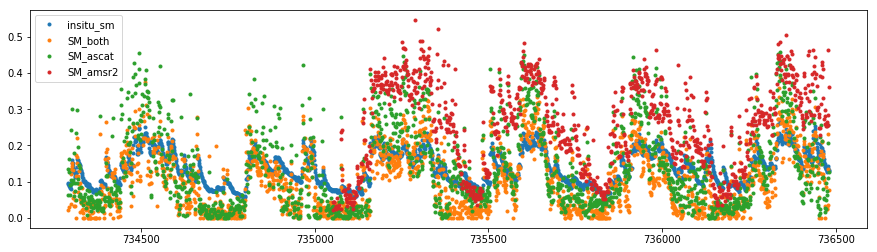

In [136]:
plt.figure(figsize=[15,4])
from scipy.io import loadmat
data = loadmat('gapFilling_REMEDHUS.mat')
plt.plot(data['utc_ref'], data['insitu_sm'], '.', label = 'insitu_sm')
plt.plot(data['utc_ref'], data['SM_both'], '.', label = 'SM_both')
plt.plot(data['utc_ref'], data['SM_ascat'], '.', label = 'SM_ascat')
plt.plot(data['utc_ref'], data['SM_amsr2'], '.', label = 'SM_amsr2')
#plt.plot(data['utc_ref'], data['SM_noah'], '.', label = 'SM_noah')
#plt.plot(data['utc_ref'], data['SM_merra'], '.', label = 'SM_merra')
rain = data['insitu_precip']
plt.legend()

In [87]:
t = np.arange(len(data['utc_ref'])).reshape(-1,1)
y1 = data['SM_both']; y1good = np.isfinite(y1); t1 = t[y1good].reshape(-1,1); y1 = y1[y1good].reshape(-1,1)
y2 = data['SM_ascat']; y2good = np.isfinite(y2); t2 = t[y2good].reshape(-1,1); y2 = y2[y2good].reshape(-1,1)
y3 = data['SM_amsr2']; y3good = np.isfinite(y3); t3 = t[y3good].reshape(-1,1); y3 = y3[y3good].reshape(-1,1)

In [211]:
satnames = ['SM_both','SM_ascat','SM_amsr2']

# Fit latent forces by classic LFM procedure (maxi marg. likelihood)

In [88]:
%load_ext autoreload
%autoreload
import sys
from LFM import LFM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
%%time
p = 3
nlf = 1
initlogparams = {
        'lengthscales':[np.log(0.1)],
        'decays':[np.log(0.01)] * p,
        'sigmas':[np.log(0.001)] * p,
        'couplings':[[np.log(1)] * p] * nlf
}
fixparams = {k: False for k in initlogparams.keys()}
#fixparams['lengthscales'] = True
#fixparams['decays'] = True
#fixparams['sigmas'] = True
#fixparams['couplings'] = True

lfm = LFM(p=p, nlf=nlf, init_logparams=initlogparams)
lfm.fixparams = fixparams

t_train = np.arange(len(y1))
# Optimize
lfm.fit([t1,t2,t3], [y1,y2,y3], n_iter=10, n_update=1, lr=0.01)
#params = lfm.get_params()
#print('Decays', 1/params['decays'])

/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Iteration 1. Current params:
   lengthscales : [array(0.09900498)]
   decays : [array(0.0101005), array(0.0101005), array(0.0099005)]
   sigmas : [array(0.00101005), array(0.00101005), array(0.00101005)]
   couplings : [[array(0.99004983), array(0.99004983), array(1.01005017)]]
  nll:  [2483.2911256] 

Iteration 2. Current params:
   lengthscales : [array(0.09801987)]
   decays : [array(0.01020201), array(0.01020201), array(0.00980199)]
   sigmas : [array(0.0010202), array(0.0010202), array(0.0010202)]
   couplings : [[array(0.98019867), array(0.98019867), array(1.02020134)]]
  nll:  [1803.61094377] 

Iteration 3. Current params:
   lengthscales : [array(0.09704455)]
   decays : [array(0.01030455), array(0.01030455), array(0.00970446)]
   sigmas : [array(0.00103045), array(0.00103045), array(0.00103045)]
   couplings : [[array(0.97044553), array(0.97044553), array(1.03045453)]]
  nll:  [1154.56490701] 

Iteration 4. Current params:
   lengthscales : [array(0.09607894)]
   decays : [arr

In [200]:
%%time
lfm.fit([t1,t2,t3], [y1,y2,y3], n_iter=100, n_update=10, lr=0.001)

/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Iteration 10. Current params:
   lengthscales : [array(0.0115606)]
   decays : [array(0.01422773), array(0.01495308), array(0.00757467)]
   sigmas : [array(0.00115622), array(0.00238694), array(0.00147422)]
   couplings : [[array(0.16259298), array(0.22253869), array(0.20336049)]]
  nll:  [-7504.01665032] 

Iteration 20. Current params:
   lengthscales : [array(0.01156617)]
   decays : [array(0.01426566), array(0.01500082), array(0.00760675)]
   sigmas : [array(0.00115579), array(0.0023887), array(0.00147326)]
   couplings : [[array(0.16269627), array(0.22286429), array(0.20316627)]]
  nll:  [-7504.26883406] 

Iteration 30. Current params:
   lengthscales : [array(0.01155901)]
   decays : [array(0.01432644), array(0.01509495), array(0.00765622)]
   sigmas : [array(0.00115599), array(0.00238552), array(0.00147005)]
   couplings : [[array(0.16273576), array(0.22285095), array(0.20306135)]]
  nll:  [-7504.46045491] 

Iteration 40. Current params:
   lengthscales : [array(0.01156077)]
   d

[('lengthscales', array([0.00936318])), ('decays', array([0.01488568, 0.01437923, 0.00795467])), ('sigmas', array([0.00114358, 0.00361372, 0.0014058 ])), ('couplings', array([[0.15700607, 0.23243708, 0.19564589]]))]
[('lengthscales', array([0.00936318])), ('decays', array([0.01488568, 0.01437923, 0.00795467])), ('sigmas', array([0.00114358, 0.00361372, 0.0014058 ])), ('couplings', array([[0.15700607, 0.23243708, 0.19564589]]))]
[('lengthscales', array([0.00936318])), ('decays', array([0.01488568, 0.01437923, 0.00795467])), ('sigmas', array([0.00114358, 0.00361372, 0.0014058 ])), ('couplings', array([[0.15700607, 0.23243708, 0.19564589]]))]


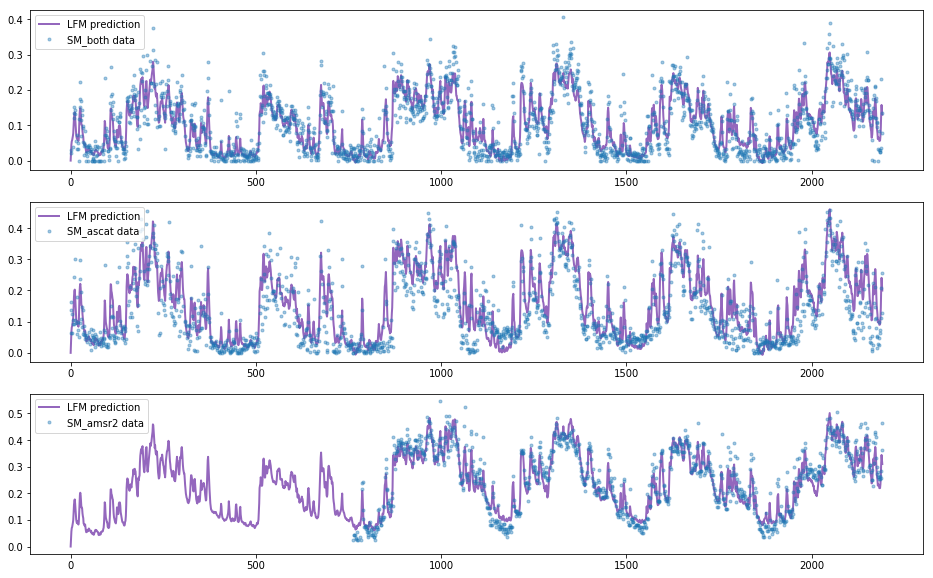

In [361]:
#### Generate test data
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=[16,10])
for sat in range(3):
    pred,pred_lf,k,k_lf = lfm.predict(t, [t1,t2,t3], [y1,y2,y3], whichp=sat, latent=True)
    ax[sat].plot(t, pred , '-',color='C4',lw=2,label='LFM prediction')
    ax[sat].plot([t1,t2,t3][sat],[y1,y2,y3][sat],'.',alpha=0.4,color='C0',label=satnames[sat]+' data')
    ax[sat].legend()

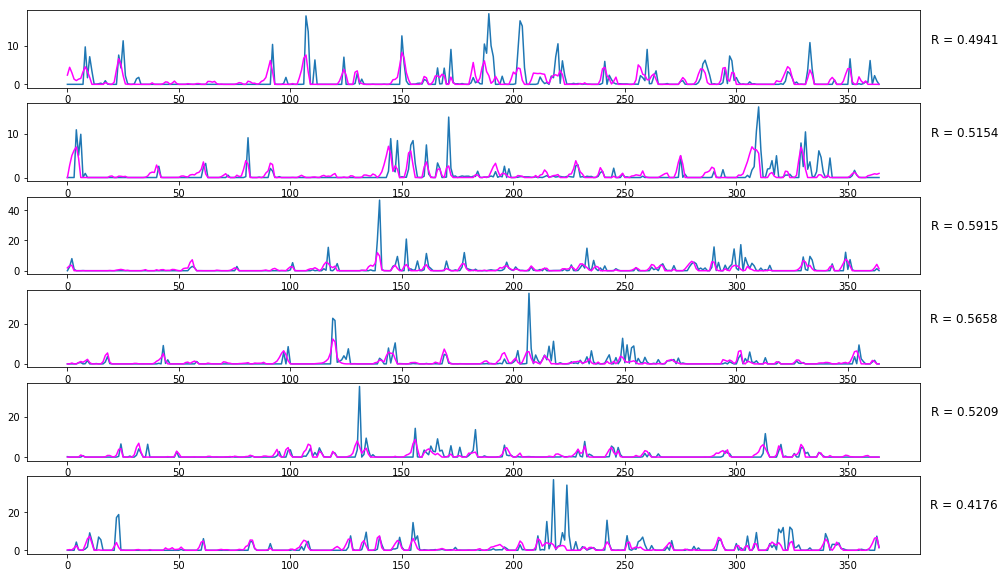

In [363]:
fig,ax = plt.subplots(nrows=6,ncols=1,figsize=[16,10])
whichlf = 0
for year in range(6):
    precip=rain[year*365:(year+1)*365]
    lf=np.maximum(0,pred_lf[whichlf*2192+year*365:whichlf*2192+(year+1)*365])*30
    ax[year].plot(precip)
    ax[year].plot(lf,color='magenta')
    ax[year].set_title("R = {0:.4g}".format(performancemetrics(precip,lf)[2]), x=1.05,y=0.5)

# Two latent forces

In [ ]:
%%time
p = 3
nlf = 2
initlogparams = {
        'lengthscales':[np.log(0.1), np.log(0.5)],
        'decays':[np.log(0.01)] * p,
        'sigmas':[np.log(0.001)] * p,
        'couplings':[[np.log(1)] * p] * nlf
}
fixparams = {k: False for k in initlogparams.keys()}

lfm_2lf = LFM(p=p, nlf=nlf, init_logparams=initlogparams)
lfm_2lf.fixparams = fixparams

In [ ]:
%%time
lfm_2lf.fit([t1,t2,t3], [y1,y2,y3], n_iter=100, n_update=10, lr=0.001)

[('lengthscales', array([0.00473977, 0.02516148, 0.1       , 0.5       ])), ('decays', array([0.04296559, 0.05052852, 0.0209229 ])), ('sigmas', array([0.00115242, 0.00151128, 0.0004378 ])), ('couplings', array([[0.1879961 , 0.31712359, 0.13746435],
       [0.10231436, 0.13796695, 0.14435838]]))]
[('lengthscales', array([0.00473977, 0.02516148, 0.1       , 0.5       ])), ('decays', array([0.04296559, 0.05052852, 0.0209229 ])), ('sigmas', array([0.00115242, 0.00151128, 0.0004378 ])), ('couplings', array([[0.1879961 , 0.31712359, 0.13746435],
       [0.10231436, 0.13796695, 0.14435838]]))]
[('lengthscales', array([0.00473977, 0.02516148, 0.1       , 0.5       ])), ('decays', array([0.04296559, 0.05052852, 0.0209229 ])), ('sigmas', array([0.00115242, 0.00151128, 0.0004378 ])), ('couplings', array([[0.1879961 , 0.31712359, 0.13746435],
       [0.10231436, 0.13796695, 0.14435838]]))]


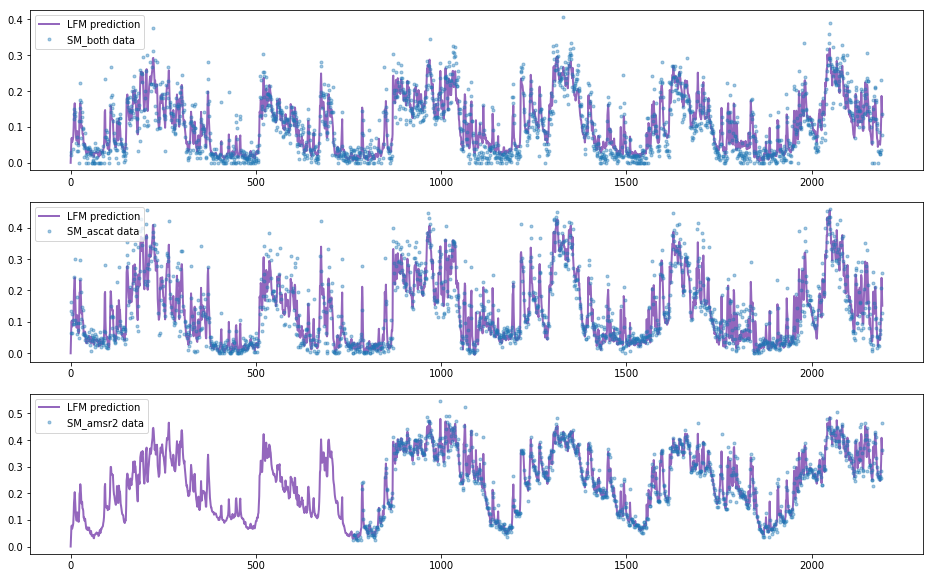

In [350]:
#### Generate test data
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=[16,10])
for sat in range(3):
    pred,pred_lf,k,k_lf = lfm_2lf.predict(t, [t1,t2,t3], [y1,y2,y3], whichp=sat, latent=True)
    ax[sat].plot(t, pred , '-',color='C4',lw=2,label='LFM prediction')
    ax[sat].plot([t1,t2,t3][sat],[y1,y2,y3][sat],'.',alpha=0.4,color='C0',label=satnames[sat]+' data')
    ax[sat].legend()

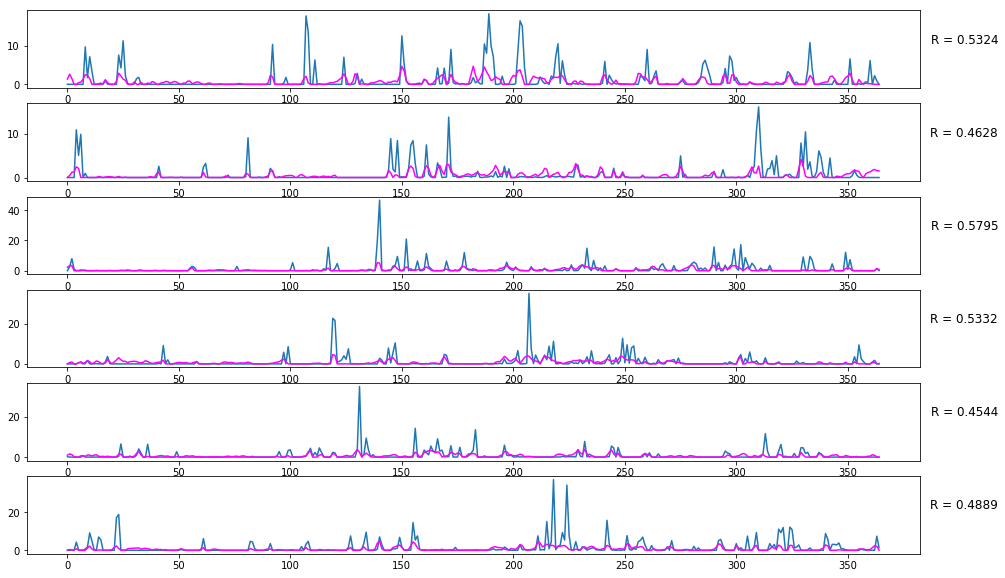

In [351]:
fig,ax = plt.subplots(nrows=6,ncols=1,figsize=[16,10])
whichlf = 0
for year in range(6):
    precip=rain[year*365:(year+1)*365]
    lf=np.maximum(0,pred_lf[whichlf*2192+year*365:whichlf*2192+(year+1)*365])*30
    ax[year].plot(precip)
    ax[year].plot(lf,color='magenta')
    ax[year].set_title("R = {0:.4g}".format(performancemetrics(precip,lf)[2]), x=1.05,y=0.5)

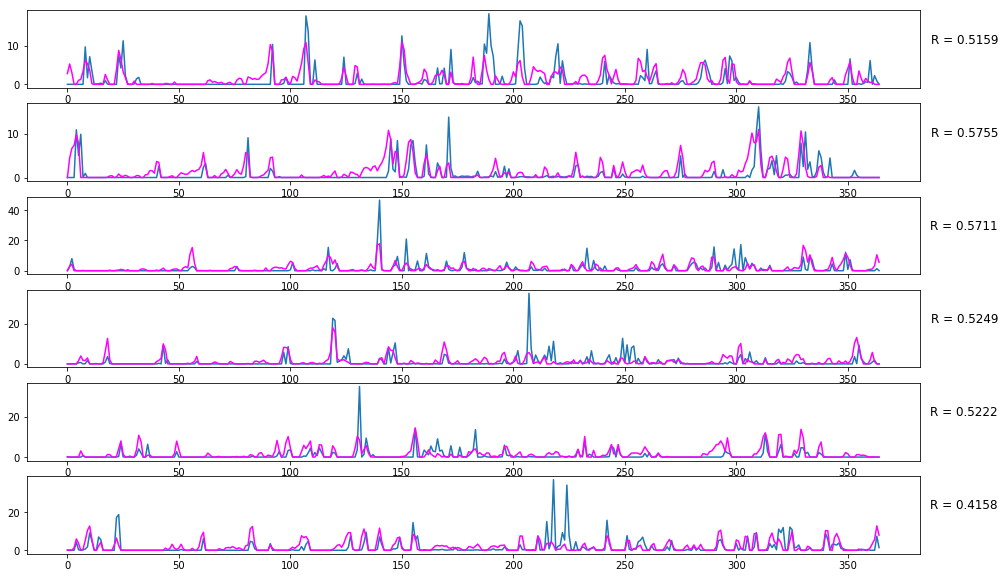

In [352]:
fig,ax = plt.subplots(nrows=6,ncols=1,figsize=[16,10])
whichlf = 1
for year in range(6):
    precip=rain[year*365:(year+1)*365]
    lf=np.maximum(0,pred_lf[whichlf*2192+year*365:whichlf*2192+(year+1)*365])*30
    ax[year].plot(precip)
    ax[year].plot(lf,color='magenta')
    ax[year].set_title("R = {0:.4g}".format(performancemetrics(precip,lf)[2]), x=1.05,y=0.5)

### Multiply

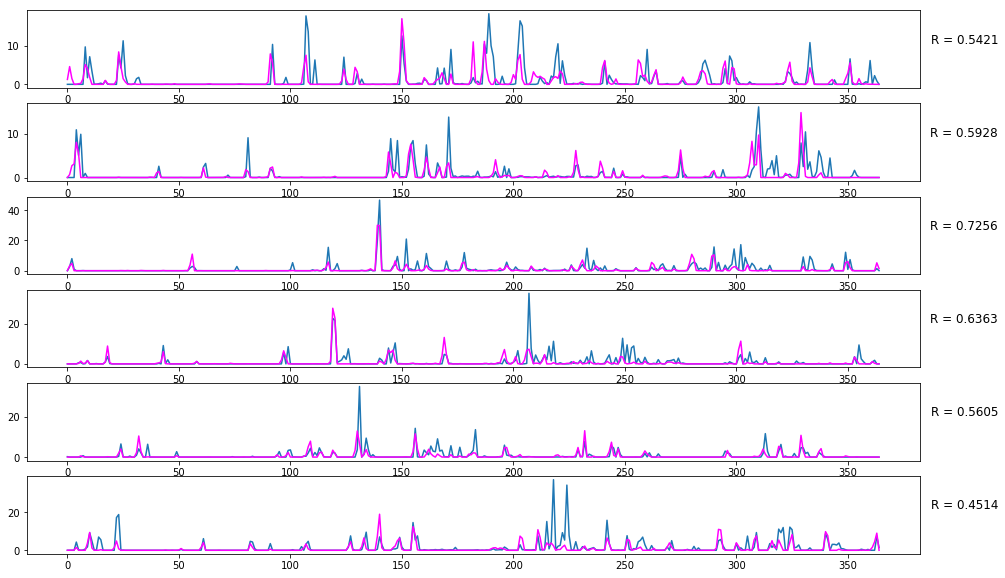

In [354]:
fig,ax = plt.subplots(nrows=6,ncols=1,figsize=[16,10])
whichlf = "MULTIPLY"
for year in range(6):
    precip=rain[year*365:(year+1)*365]
    lf=np.maximum(0,pred_lf[0*2192+year*365:0*2192+(year+1)*365])*np.maximum(0,pred_lf[1*2192+year*365:1*2192+(year+1)*365])*300
    ax[year].plot(precip)
    ax[year].plot(lf,color='magenta')
    ax[year].set_title("R = {0:.4g}".format(performancemetrics(precip,lf)[2]), x=1.05,y=0.5)

# Three LF

In [ ]:
%%time
p = 3
nlf = 3
initlogparams = {
        'lengthscales':[np.log(0.1), np.log(0.5), np.log(1.0)],
        'decays':[np.log(0.01)] * p,
        'sigmas':[np.log(0.001)] * p,
        'couplings':[[np.log(1)] * p] * nlf
}
fixparams = {k: False for k in initlogparams.keys()}

lfm_3lf = LFM(p=p, nlf=nlf, init_logparams=initlogparams)
lfm_3lf.fixparams = fixparams

In [ ]:
%%time
lfm_3lf.fit([t1,t2,t3], [y1,y2,y3], n_iter=100, n_update=10, lr=0.001)

[('lengthscales', array([3.52253515e-03, 1.98571747e-02, 7.19755938e+01])), ('decays', array([0.06167397, 0.09057853, 0.06145979])), ('sigmas', array([0.00089455, 0.00126292, 0.00051769])), ('couplings', array([[0.1777341 , 0.37997506, 0.13737552],
       [0.13071896, 0.15252194, 0.15718346],
       [0.00610867, 0.0122924 , 0.01443852]]))]
[('lengthscales', array([3.52253515e-03, 1.98571747e-02, 7.19755938e+01])), ('decays', array([0.06167397, 0.09057853, 0.06145979])), ('sigmas', array([0.00089455, 0.00126292, 0.00051769])), ('couplings', array([[0.1777341 , 0.37997506, 0.13737552],
       [0.13071896, 0.15252194, 0.15718346],
       [0.00610867, 0.0122924 , 0.01443852]]))]
[('lengthscales', array([3.52253515e-03, 1.98571747e-02, 7.19755938e+01])), ('decays', array([0.06167397, 0.09057853, 0.06145979])), ('sigmas', array([0.00089455, 0.00126292, 0.00051769])), ('couplings', array([[0.1777341 , 0.37997506, 0.13737552],
       [0.13071896, 0.15252194, 0.15718346],
       [0.00610867, 0.

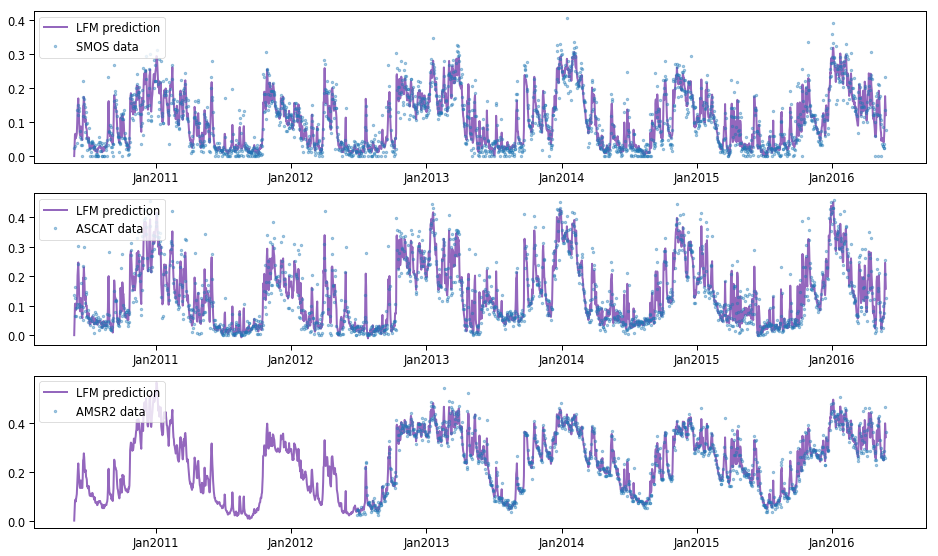

In [406]:
#### Generate test data
satnames = ['SMOS','ASCAT','AMSR2']
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=[16,9.5])
for sat in range(3):
    pred,pred_lf,k,k_lf = lfm_3lf.predict(t, [t1,t2,t3], [y1,y2,y3], whichp=sat, latent=True)
    ax[sat].plot(t, pred , '-',color='C4',lw=2,label='LFM prediction')
    ax[sat].plot([t1,t2,t3][sat],[y1,y2,y3][sat],'.',alpha=0.4,color='C0',label=satnames[sat]+' data')
    ssh=ax[sat].set_xticks([221+i*365 for i in range(6)])
    shh=ax[sat].set_xticklabels(['Jan20'+str(i) for i in range(11,17)])
    ax[sat].legend(loc='upper left')
plt.savefig('3lfpred.png',bbox_inches='tight')

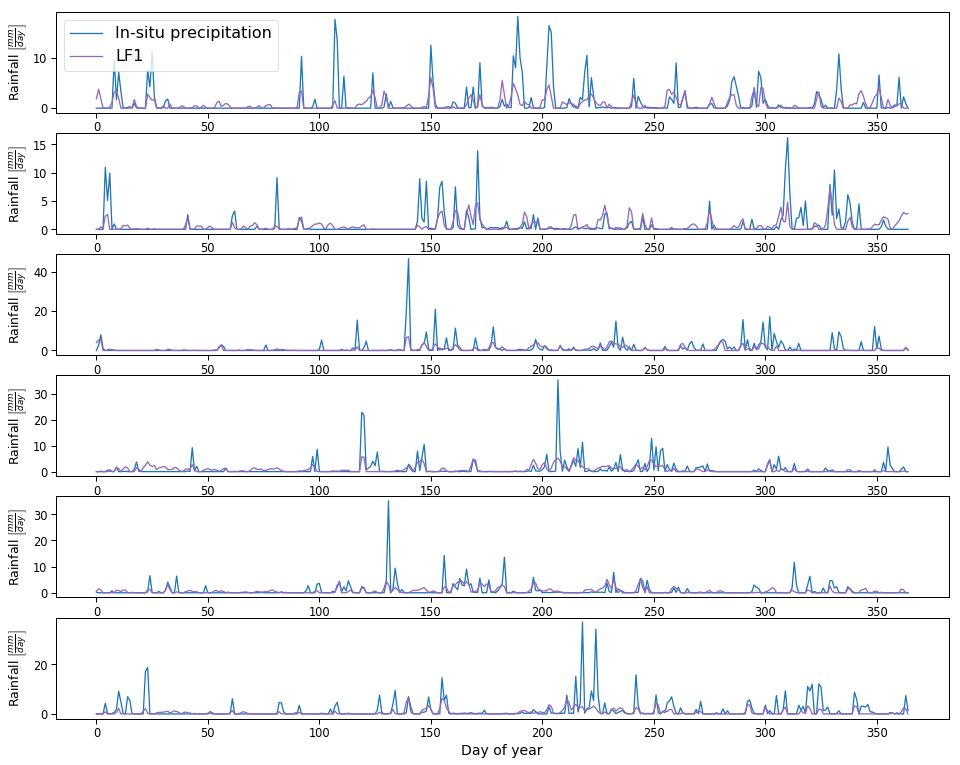

In [752]:
fig,ax = plt.subplots(nrows=6,ncols=1,figsize=[16,13])
whichlf = 0
for year in range(6):
    precip=rain[year*365:(year+1)*365]
    lf=np.maximum(0,pred_lf[whichlf*2192+year*365:whichlf*2192+(year+1)*365])*50
    ax[year].plot(precip,lw=1.3,label='In-situ precipitation')
    ax[year].set_ylabel(r'Rainfall $\left[ \frac{mm}{day} \right]$')
    ax[year].plot(lf,lw=1.3,color='C4', label='LF1')#'magenta')
    #ax[year].set_title("R = {0:.4g}".format(performancemetrics(precip,lf)[2]), x=1.05,y=0.5)
ax[0].legend(loc='upper left',fontsize=16)
ax[5].set_xlabel('Day of year',fontsize=14)
plt.savefig('3lf_lf1.png',bbox_inches='tight')

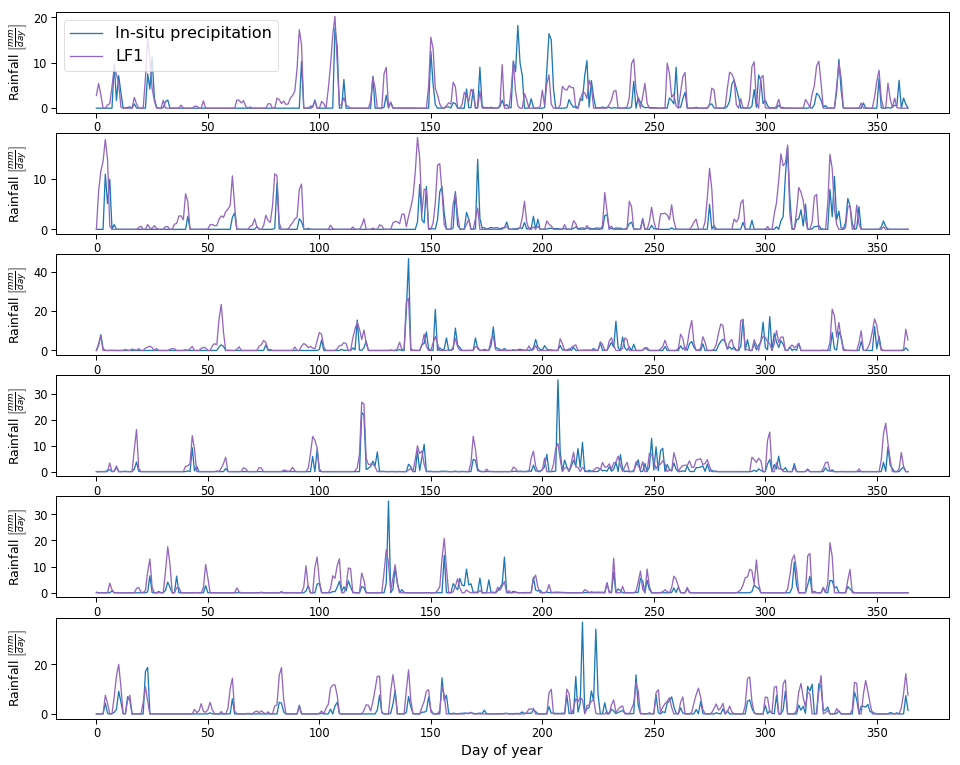

In [753]:
fig,ax = plt.subplots(nrows=6,ncols=1,figsize=[16,13])
whichlf = 1
for year in range(6):
    precip=rain[year*365:(year+1)*365]
    lf=np.maximum(0,pred_lf[whichlf*2192+year*365:whichlf*2192+(year+1)*365])*50
    ax[year].plot(precip,lw=1.3,label='In-situ precipitation')
    ax[year].set_ylabel(r'Rainfall $\left[ \frac{mm}{day} \right]$')
    ax[year].plot(lf,lw=1.3,color='C4', label='LF1')#'magenta')
    #ax[year].set_title("R = {0:.4g}".format(performancemetrics(precip,lf)[2]), x=1.05,y=0.5)
ax[0].legend(loc='upper left',fontsize=16)
ax[5].set_xlabel('Day of year',fontsize=14)
plt.savefig('3lf_lf2.png',bbox_inches='tight')

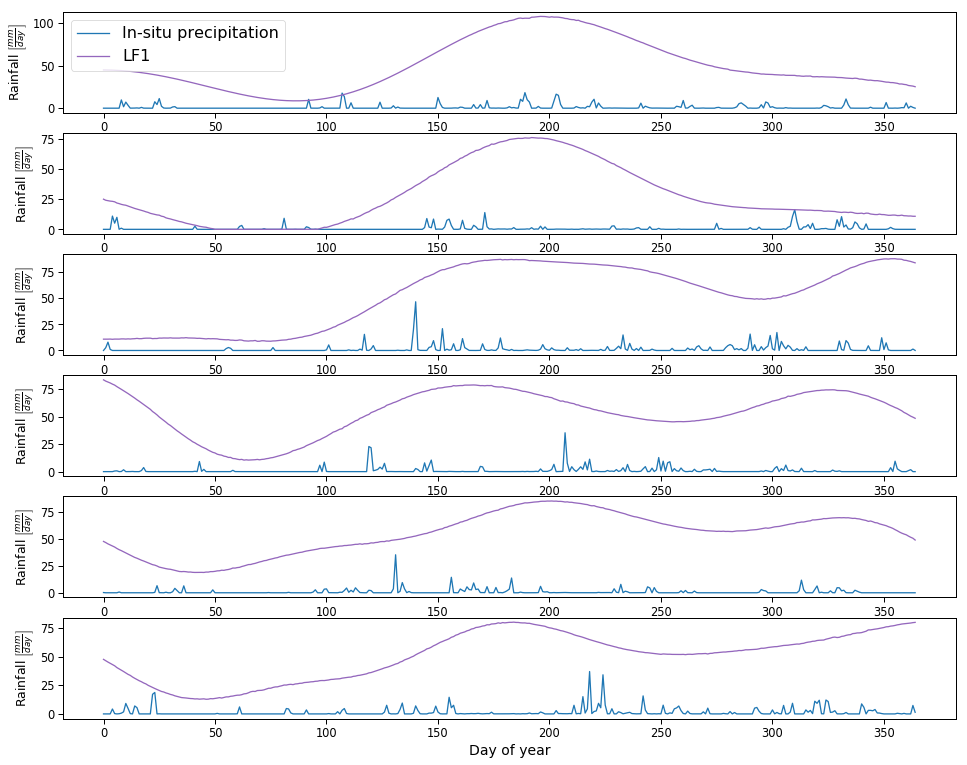

In [755]:
fig,ax = plt.subplots(nrows=6,ncols=1,figsize=[16,13])
whichlf = 2
for year in range(6):
    precip=rain[year*365:(year+1)*365]
    lf=np.maximum(0,pred_lf[whichlf*2192+year*365:whichlf*2192+(year+1)*365])*50
    ax[year].plot(precip,lw=1.3,label='In-situ precipitation')
    ax[year].set_ylabel(r'Rainfall $\left[ \frac{mm}{day} \right]$')
    ax[year].plot(lf,lw=1.3,color='C4', label='LF1')#'magenta')
    #ax[year].set_title("R = {0:.4g}".format(performancemetrics(precip,lf)[2]), x=1.05,y=0.5)
ax[0].legend(loc='upper left',fontsize=16)
ax[5].set_xlabel('Day of year',fontsize=14)
plt.savefig('3lf_lf3.png',bbox_inches='tight')

### Multiply

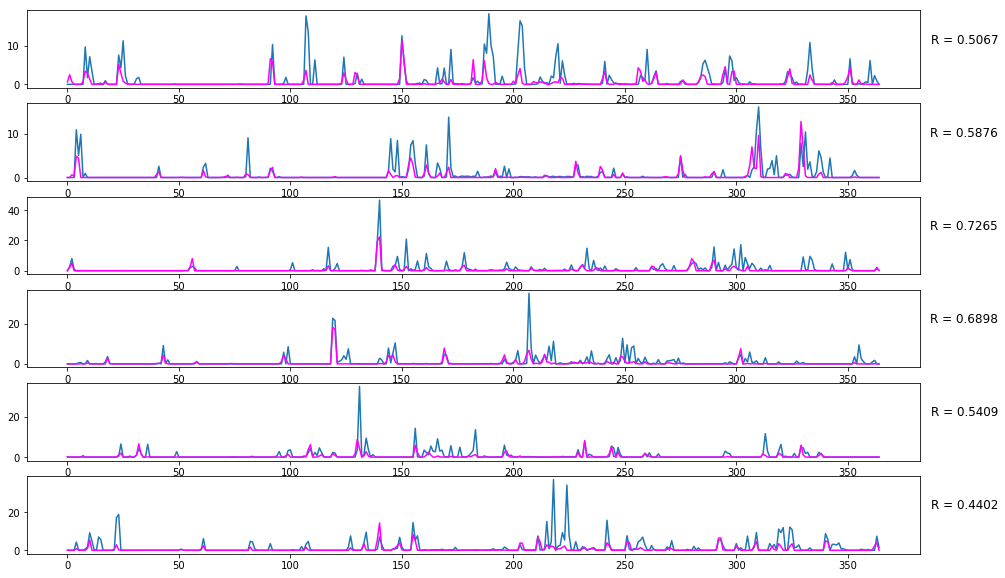

In [360]:
fig,ax = plt.subplots(nrows=6,ncols=1,figsize=[16,10])
whichlf = "MULTIPLY"
for year in range(6):
    precip=rain[year*365:(year+1)*365]
    lf=np.maximum(0,pred_lf[0*2192+year*365:0*2192+(year+1)*365])*np.maximum(0,pred_lf[1*2192+year*365:1*2192+(year+1)*365])*300
    ax[year].plot(precip)
    ax[year].plot(lf,color='magenta')
    ax[year].set_title("R = {0:.4g}".format(performancemetrics(precip,lf)[2]), x=1.05,y=0.5)